In [21]:
import sys, os
sys.path.append('../')
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from inversion_attacks import GradientInversion_Attack
from inversion_attacks.utils.utils import NumpyDataset, ConservativeStrategy, plot, multi_plot
from inversion_attacks.utils.models import LeNet, ConvNet
from inversion_attacks.utils.evaluation_metrics import psnr
from inversion_attacks.utils.consts import *
from inversion_attacks.utils.dataloader import construct_dataloaders

import numpy as np
from PIL import Image

from IQA_pytorch import SSIM 
import lpips 
import csv 


In [2]:
torch.manual_seed(1)
num_classes = 1000
channel = 3
device = torch.device("cuda:2") if torch.cuda.is_available() else "cpu"
setup = dict(device=device, dtype=torch.float)  
print(setup)
defs = ConservativeStrategy()
batch_size = 1

{'device': device(type='cuda', index=2), 'dtype': torch.float32}


In [3]:
# dm = torch.as_tensor(imagenet_mean, **setup)[:, None, None] 
# ds = torch.as_tensor(imagenet_std, **setup)[:, None, None] 

dm = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None]
ds = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None] 

loss_fn, dataloader, validloader =  construct_dataloaders('ImageNet', defs,data_path='/data2/imagenet2012/')

In [4]:
img_idx = 8112
img, label = validloader.dataset[img_idx]
labels = torch.as_tensor((label,), device=device)
ground_truth = img.to(**setup).unsqueeze(0)
shape_img=tuple(ground_truth[0].shape)

print(shape_img)
print(ground_truth.shape)
print("seed label: ", labels, labels.shape)

(3, 224, 224)
torch.Size([1, 3, 224, 224])
seed label:  tensor([162], device='cuda:2') torch.Size([1])


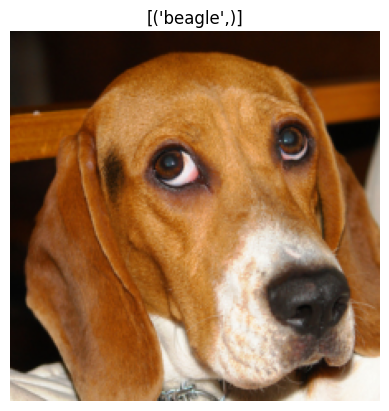

In [5]:
img = ground_truth.clone().detach().to(**setup)
img.mul_(ds).add_(dm).clamp_(0, 1)
plt.imshow(img[0].permute(1, 2, 0).cpu())
plt.axis("off")
plt.title(str([validloader.dataset.classes[l] for l in labels]))
plt.show()

In [6]:
# net = getattr(torchvision.models, 'resnet50')()
net = getattr(torchvision.models, 'resnet18')()
# net = LeNet(channel=channel, hideen=37632, num_classes=num_classes)
# net = ConvNet(num_classes=num_classes)
net = net.to(device)

In [7]:
bn_reg_layers = list()
for layer in net.modules():
    if isinstance(layer,torch.nn.modules.batchnorm.BatchNorm2d): 
        bn_reg_layers.append(layer)
print(len(bn_reg_layers))

20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])


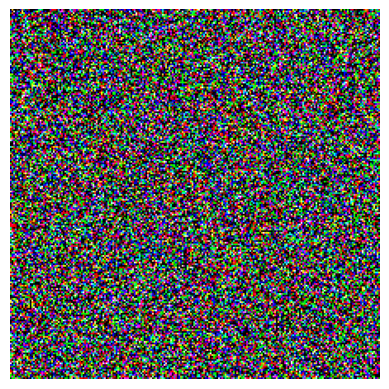

In [8]:
# x_init = torch.randn(ground_truth.shape,requires_grad=True,).to(**setup)
x_init = torch.randn((batch_size,) + (shape_img), requires_grad=True, device=device)
print(x_init.shape)
plt.imshow(x_init[0].permute(1, 2, 0).detach().cpu().numpy())
plt.axis("off")
plt.show()

In [9]:
net.eval()
net.zero_grad()
ground_truth.requires_grad = True

In [10]:
pred = net(ground_truth)
loss, _, _ = loss_fn(pred, labels)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]
print(len(received_gradients))

62


In [11]:
# dlg_attacker_1 = GradientInversion_Attack(
#         net, 
#         shape_img, 
#         mean_std=(dm,ds), 
#         lr=1.0,#1.0, 
#         log_interval=100, 
#         num_iteration=3000, 
#         distancename="l2",
#         device=device,early_stopping=1000,
#         lr_decay=True,
#         optimize_label=True
#     )

# gs_attacker_1 = GradientInversion_Attack(
#             net,
#             shape_img,
#             mean_std=(dm,ds),
#             lr=1.0, #lr=1.0,
#             log_interval=100,
#             num_iteration=10000,
#             tv_reg_coef=1e-6,
#             #tv_reg_coef=0.001,
#             distancename="cossim",
#             optimizer_class=torch.optim.Adam,
#             device=device,early_stopping=5000,
#             optimize_label=True,
#             lr_decay=True
#             # clamp_range=(0,1)
#         )

# idlg_attacker_1 = GradientInversion_Attack(
#         net,
#         shape_img, 
#         mean_std=(dm,ds),
#         lr=0.001,
#         log_interval=100,
#         num_iteration=3000,
#         distancename="l2",
#         optimize_label=True,
#         optimizer_class=torch.optim.SGD,
#         lr_decay= True,
#         device=device,early_stopping=1000
#     )
    
# cpl_attacker_1 = GradientInversion_Attack(
#         net,
#         shape_img,
#         mean_std=(dm,ds),
#         lr=1.0,
#         log_interval=100,
#         num_iteration=500,
#         distancename="l2",
#         optimize_label=False,
#         lm_reg_coef=0.01,
#         device=device,early_stopping=1000
#     )

group_num = 2
gradinversion_attacker_1 = GradientInversion_Attack(
        net,
        shape_img,
        num_iteration=500,
        lr=0.1,
        #lr=1.0,
        optimizer_class=torch.optim.Adam,
        log_interval=100,
        distancename="l2",
        optimize_label=False,
        bn_reg_layers=bn_reg_layers,
        group_num=group_num,
        tv_reg_coef=0.0001,
        l2_reg_coef=0.000001,
        bn_reg_coef=0.1,
        gc_reg_coef=0.001,
        device=device,early_stopping=1000
    )
    

In [12]:
num_seeds=1

import traceback
try:
    # dlg_attacker_1.reset_seed(num_seeds)
    # result = dlg_attacker_1.attack(received_gradients, init_x=x_init)

    # gs_attacker_1.reset_seed(num_seeds)
    # result = gs_attacker_1.attack(received_gradients, init_x=x_init) #, labels=labels)

    # idlg_attacker_1.reset_seed(num_seeds)
    # result = idlg_attacker_1.attack(received_gradients, init_x=x_init)

    # cpl_attacker_1.reset_seed(num_seeds)
    # result = cpl_attacker_1.attack(received_gradients,labels=labels)

    gradinversion_attacker_1.reset_seed(num_seeds)
    result = gradinversion_attacker_1.group_attack(
        received_gradients, batch_size=1
    )[0]
    
except:
    traceback.print_exc()



worker_id=0: iter=100: 16.829280853271484, (best_iter=45: 14.844620704650879)
worker_id=1: iter=100: 16.01740264892578, (best_iter=96: 15.034558296203613)
worker_id=0: iter=200: 14.636960983276367, (best_iter=197: 13.220693588256836)
worker_id=1: iter=200: 17.632219314575195, (best_iter=150: 13.917218208312988)
worker_id=0: iter=300: 13.874987602233887, (best_iter=223: 12.760713577270508)
worker_id=1: iter=300: 14.890365600585938, (best_iter=281: 13.449777603149414)
worker_id=0: iter=400: 13.346680641174316, (best_iter=358: 12.69200325012207)
worker_id=1: iter=400: 13.83492660522461, (best_iter=353: 12.664082527160645)
worker_id=0: iter=500: 15.261079788208008, (best_iter=407: 12.281825065612793)
worker_id=1: iter=500: 14.754770278930664, (best_iter=469: 11.9627103805542)


<Figure size 700x800 with 0 Axes>

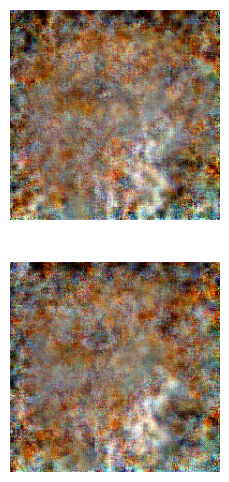

In [36]:
plt.figure(figsize=(7,8))
output = result[0]
plot(output,ds,dm)
# plt.savefig(os.path.join("./", 'GS_output.png')) 
# multi_plot(torch.stack(result, dim=0).squeeze(),ds,dm)

In [14]:
# evaluation
output = result[0]
test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (net(output.detach())- net(ground_truth)).pow(2).mean()  
#test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)
test_psnr = psnr(output, ground_truth, factor=1/ds)

D = SSIM(channels=3)
test_ssim = D(output.detach(), ground_truth, as_loss=False).mean()

lpips_loss = lpips.LPIPS(net='vgg', spatial=True).to(**setup)
lpips_score = lpips_loss.forward(ground_truth, output.detach()).mean()

print(test_mse.item())
print(feat_mse.item())
print(test_ssim.item())
print(test_psnr)
print(lpips_score.item())

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]


/home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/msyu/anaconda3/envs/hybrid/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
0.25150683522224426
9.573193892720155e-06
0.03868095204234123
12.01510238647461
0.8358993530273438


In [15]:
test_mse_list = []
feat_mse_list = []
test_psnr_list = []
test_ssim_list = [] 
lpips_score_list = [] 


lpips_score_list.append(lpips_score.item())
test_mse_list.append(test_mse.item())
test_ssim_list.append(test_ssim.item())
feat_mse_list.append(feat_mse.item())
test_psnr_list.append(test_psnr)

In [16]:

results_list = [[0],test_mse_list, feat_mse_list, test_psnr_list, test_ssim_list, lpips_score_list]
column_list = ['parital_ratio', 'mse', 'feat_mse', 'psnr', 'ssim', 'lpips']
with open(os.path.join('./', 'results_HE_ratio.csv'), 'a') as f:
    wr = csv.writer(f)
    for i in range(len(results_list)):
        wr.writerow([column_list[i]] + results_list[i])

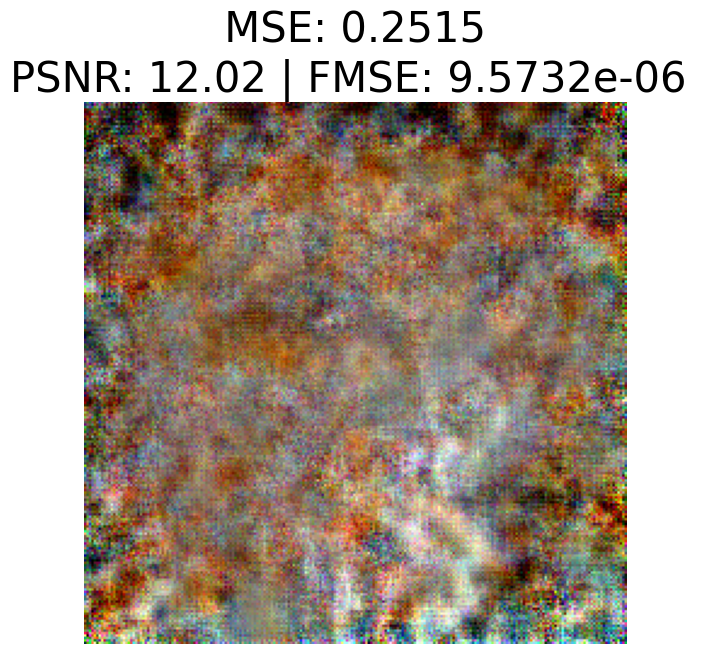

In [17]:
plt.figure(figsize=(7,8))
plot(output,ds,dm)
# plt.title(f"loss: {gs_attacker_1.get_best_loss():2.4f} | MSE: {test_mse:2.4f} \n"
#             f"PSNR: {test_psnr:3.2f} | FMSE: {feat_mse:2.4e} ")

plt.title(f" MSE: {test_mse:2.4f} \n"
            f"PSNR: {test_psnr:3.2f} | FMSE: {feat_mse:2.4e} ")

plt.savefig(os.path.join("./", 'GS_resnet50_output.png')) 

In [18]:
# from torchsummary import summary
# summary(net, shape_img)
# print()